In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pmd
import pandas_datareader as pdr
import datetime as dt

In [213]:
# Load Amazon data
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime.now()

amzn = pdr.DataReader('AMZN', 'yahoo', start_date, end_date)

In [214]:
# Check dataframe
amzn

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,89.562500,79.046875,81.500000,89.375000,16117600,89.375000
2000-01-04,91.500000,81.750000,85.375000,81.937500,17487400,81.937500
2000-01-05,75.125000,68.000000,70.500000,69.750000,38457400,69.750000
2000-01-06,72.687500,64.000000,71.312500,65.562500,18752000,65.562500
2000-01-07,70.500000,66.187500,67.000000,69.562500,10505400,69.562500
...,...,...,...,...,...,...
2022-05-23,2176.379883,2079.000000,2169.219971,2151.139893,5389900,2151.139893
2022-05-24,2108.000000,2025.199951,2080.500000,2082.000000,5146700,2082.000000
2022-05-25,2163.500000,2073.000000,2073.110107,2135.500000,4656000,2135.500000


In [215]:
amzn = amzn['Close']

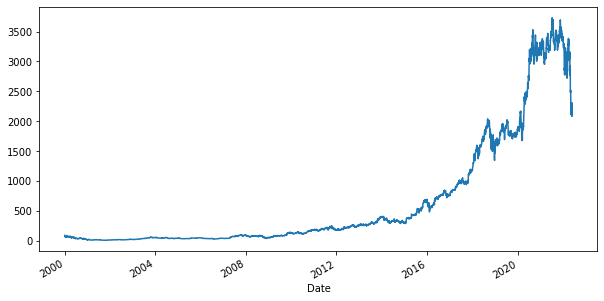

In [216]:
amzn.plot(figsize=(10, 5));

In [227]:
# Set day count
test_days = 30

# Split into train and test datasets
train = amzn.iloc[:-test_days]
test = amzn.iloc[-test_days:]

In [228]:
model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=54882.543, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=53186.593, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=50909.815, Time=0.68 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=54880.544, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 5.879 seconds


In [229]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5608
Model:               SARIMAX(0, 2, 1)   Log Likelihood              -25451.908
Date:                Sat, 28 May 2022   AIC                          50909.815
Time:                        09:20:36   BIC                          50929.710
Sample:                             0   HQIC                         50916.748
                               - 5608                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.374e-05      0.003     -0.029      0.977      -0.006       0.006
ma.L1         -0.9892      0.001   -871.285      0.000      -0.991      -0.987
sigma2       496.5491      2.163    229.525      0.000     492.309     500.789
===================================================================================
Ljung-Box (L1) (Q):                   4.82   Jarque-Bera (JB):            319975.88
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):             727.68   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [230]:
model.get_params()

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (0, 2, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [222]:
def plot_result(model, data, train, test):
    # Ploting the price graph to check model results 
    params = model.get_params()
    d = params['order'][1]
    
    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=test_days, return_conf_int=True)
    
    fix, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data.index, data, label='Данные')
    ax.plot(train.index[d:], train_pred, label='Тренировка')
    ax.plot(test.index, test_pred, label='Прогноз')
    
    ax.fill_between(test.index, confint[:, 0], confint[:, 1], color='red',
                   alpha=0.3)
    ax.legend()
    

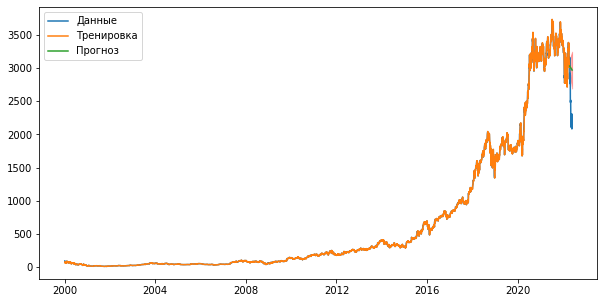

In [231]:
plot_result(model, amzn, train, test)

In [232]:
def plot_test(model, test):
    # Ploting more dateiled graph with intervals and increased scale
    test_pred, confint = model.predict(n_periods=test_days, return_conf_int=True)
    
    fix, ax = plt.subplots(figsize=(10, 5))
    ax.plot(test.index, test, label='Данные')
    ax.plot(test.index, test_pred, label='Прогноз')
    ax.fill_between(test.index, confint[:, 0], confint[:, 1], color='red',
                   alpha=0.3)
    ax.legend()
    
def rmse(y, t):
    # Calculate root mean square error
    return np.sqrt(np.mean((t - y))**2)

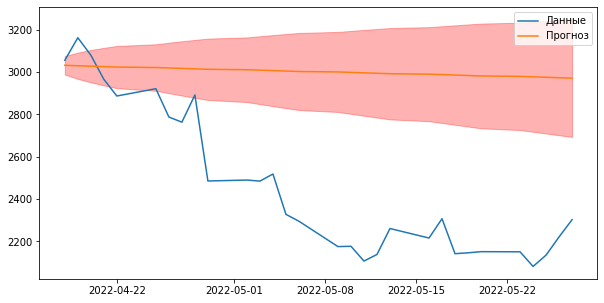

In [233]:
plot_test(model, test)

In [234]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 540.4811811525677
Naive Forecast Root-mean-square deviation: 572.9438883463541


In [235]:
# Checking Berkshire Hathaway
brka = pdr.DataReader('BRK-A', 'yahoo', start_date, end_date)

In [237]:
brka = brka['Close']

train = brka.iloc[:-test_days]
test = brka.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=107616.965, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=105572.797, Time=0.33 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=107614.966, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=104886.283, Time=0.47 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=104644.846, Time=0.61 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=104415.114, Time=0.71 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=104318.174, Time=1.02 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=103536.361, Time=1.59 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=103526.132, Time=1.24 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=103564.627, Time=1.03 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=103407.666, Time=1.37 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=103423.195, Time=1.19 sec
 ARIMA(5,2,2)(0,0,0

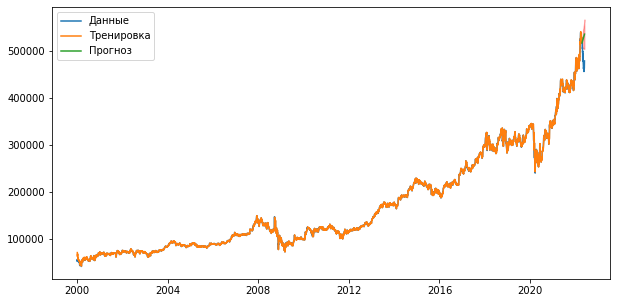

In [238]:
plot_result(model, brka, train, test)

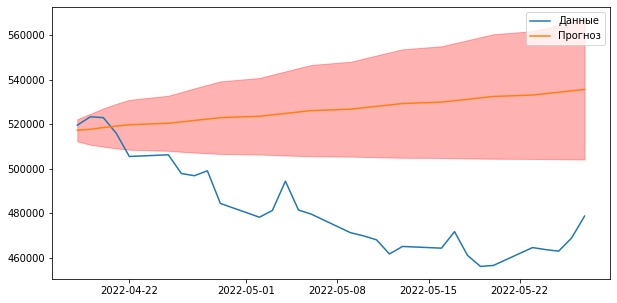

In [239]:
plot_test(model, test)

In [240]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 44063.382579652345
Naive Forecast Root-mean-square deviation: 34129.1


#### We get an unsatisfactory result again. The naive forecast turned out to be more accurate.

In [241]:
# Checking Tesla
tsla = pdr.DataReader('TSLA', 'yahoo', start_date, end_date)

In [242]:
tsla = tsla['Close']

train = tsla.iloc[:-test_days]
test = tsla.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22933.869, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22932.119, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22933.678, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22933.648, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22932.571, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22935.836, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.700 seconds


We get ARIMA(0, 1, 0), which is equivalent to Random Walk. In this situation, it is impossible to make a prediction based on previous values.

In [246]:
# Checking Nvidia
nvda = pdr.DataReader('NVDA', 'yahoo', start_date, end_date)

In [247]:
nvda = nvda['Close']

train = nvda.iloc[:-test_days]
test = nvda.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23241.835, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23288.239, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23280.236, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23279.007, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23288.383, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23236.747, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23265.665, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23277.200, Time=0.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23213.823, Time=1.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23244.700, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23214.737, Time=1.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=23215.412, Time=1.51 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=23245.934, Time=0.93 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=23213.215, Time=2.16 sec
 ARIMA(3,1,4)(0,0,0

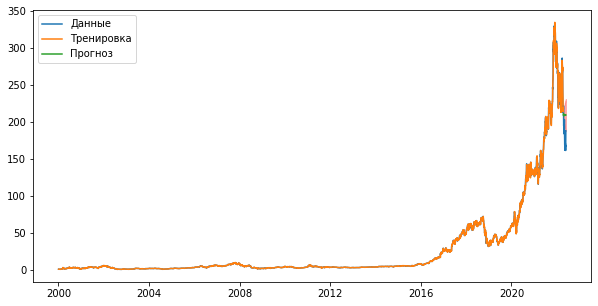

In [248]:
plot_result(model, nvda, train, test)

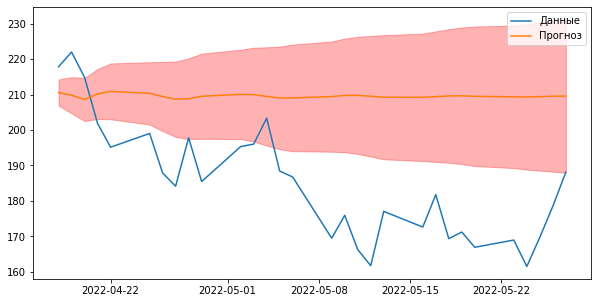

In [249]:
plot_test(model, test)

In [250]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 24.374523287572295
Naive Forecast Root-mean-square deviation: 27.405001322428387


#### We get a result better than a naive forecast, but it can hardly be considered satisfactory anyway.

In [251]:
# Checking Google
goog = pdr.DataReader('GOOG', 'yahoo', start_date, end_date)

In [252]:
goog = goog['Close']

train = goog.iloc[:-test_days]
test = goog.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=40632.083, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=39149.490, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=37383.839, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=40630.085, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=37362.679, Time=0.62 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=37364.968, Time=0.85 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=38718.361, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0] intercept
Total fit time: 5.401 seconds


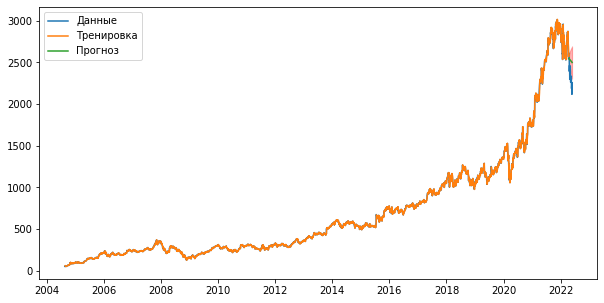

In [255]:
plot_result(model, goog, train, test)

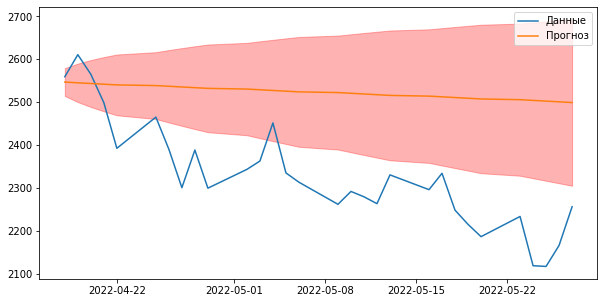

In [256]:
plot_test(model, test)

In [257]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 193.96921515736327
Naive Forecast Root-mean-square deviation: 216.06139322916667


## A similar situation. Let's try to take a smaller timeframe for forecasting.

In [258]:
test_days = 10

train = amzn.iloc[:-test_days]
test = amzn.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51611.183, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51617.545, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51611.786, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51611.785, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51617.032, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51609.124, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51613.769, Time=0.72 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51608.059, Time=1.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51615.787, Time=0.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51613.782, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51606.717, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=51611.380, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51611.381, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=51615.381, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0

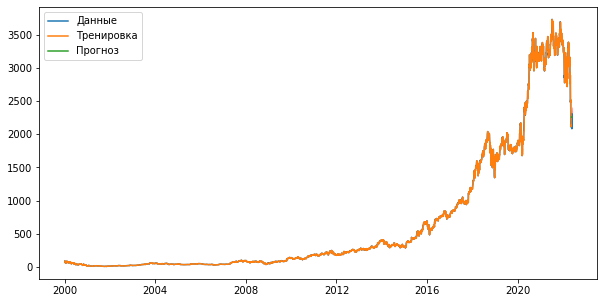

In [260]:
plot_result(model, amzn, train, test)

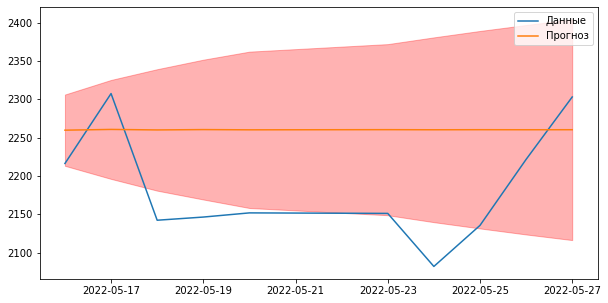

In [261]:
plot_test(model, test)

In [262]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 74.48282941157814
Naive Forecast Root-mean-square deviation: 75.385107421875


In [274]:
# Berkshire
train = brka.iloc[:-test_days]
test = brka.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=103769.073, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=103814.933, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103778.979, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=103781.839, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103817.897, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=103773.679, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=103774.638, Time=0.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=103775.703, Time=1.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=103772.247, Time=1.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=103776.144, Time=1.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=103775.893, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=103766.458, Time=1.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=103774.211, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=103768.666, Time=0.85 sec
 ARIM

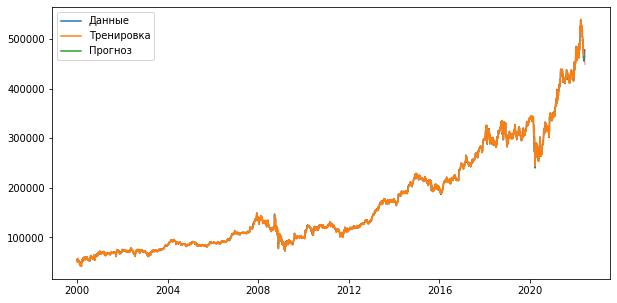

In [267]:
plot_result(model, brka, train, test)

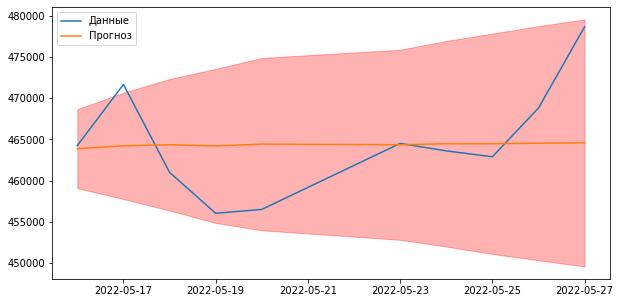

In [276]:
plot_test(model, test)

In [275]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 445.0917717618693
Naive Forecast Root-mean-square deviation: 217.8


In [269]:
# Tesla
train = tsla.iloc[:-test_days]
test = tsla.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23369.694, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23366.642, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23366.617, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23366.588, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23365.992, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23368.542, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.833 seconds


#### ARIMA(0, 1, 0). Let's make sure that this really matches the naive forecast.

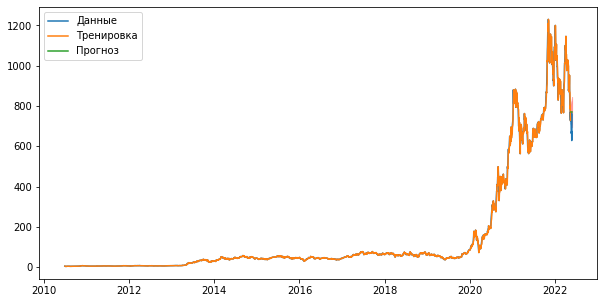

In [271]:
plot_result(model, tsla, train, test)

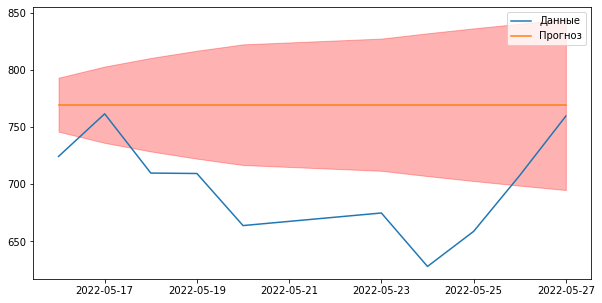

In [272]:
plot_test(model, test)

In [273]:
print("ARIMA Root-mean-square deviation:", rmse(model.predict(test_days), test))
print("Naive Forecast Root-mean-square deviation:", rmse(train.iloc[-1], test))

ARIMA Root-mean-square deviation: 69.75703125
Naive Forecast Root-mean-square deviation: 69.75703125


#### As we can see, the root mean square errors are equals.

In [277]:
# Nvidia
train = nvda.iloc[:-test_days]
test = nvda.iloc[-test_days:]

model = pmd.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23792.171, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23833.335, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23814.821, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23813.112, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23832.697, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23823.057, Time=0.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23801.503, Time=0.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23790.901, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23791.979, Time=1.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=23788.898, Time=1.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=23790.906, Time=1.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=23749.721, Time=1.71 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=23742.344, Time=1.74 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=23770.574, Time=0.74 sec
 ARIMA(4,1,0)(0,0,0

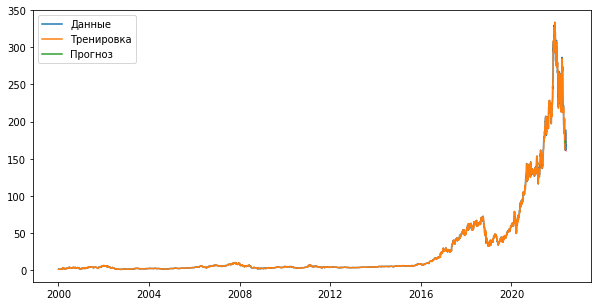

In [279]:
plot_result(model, nvda, train, test)

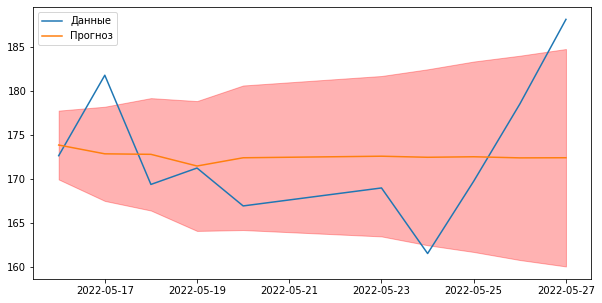

In [280]:
plot_test(model, test)

### Testing a shorter time period was much more successful. Most forecasts satisfy given confidence intervals.